# Thick Triangle

In [1]:
import kwant
import numpy as np
from math import pi
from cmath import exp
import matplotlib.pyplot as plt     
from matplotlib import cm, colors
from IPython import display
import pandas as pd
import imageio


/Users/guilhermedelfino/opt/anaconda3/lib/python3.9/site-packages/kwant/solvers/default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "


In [2]:
def label_plot(phi_ar):
    lab_size=int(np.array(phi_ar).shape[0])
    out=[]
    out_phi=[]
    print(lab_size)
    spacing=int(lab_size/6)
    for j in range(0,6):
        out.append(int(spacing*j))
        out_phi.append(round(phi_ar[int(spacing*j)],2))
    return out, out_phi

def label_ploty(delta_ar):
    lab_size=int(np.array(delta_ar).shape[0])
    out=[]
    out_phi=[]
    # print(lab_size)
    spacing=int(lab_size/5)
    for j in range(0,6):
        out.append(int(spacing*j))
        out_phi.append(delta_ar[int(spacing*j)])
    return out, out_phi


In [9]:
def on_triangle_edges(position, L, W):
    #L lenght of triangle edge
    #W width of triangle edge
    #position (i,j)
    #output: true or false if position belongs to the edge of the triangle

    x, y = position  # Get site coordinates
    
    # Edge 1: Bottom horizontal (-W <= y <= 0)
    if -W<= y <=0 and -W <= x <= L+W:
        return  True #False# True
    
    # Edge 2: Left slope (-W <= x <= 0, and 0 <= y<= L)
    if -W <= x <= 0 and (-W <= y and y+x<= L+W):
        return True
    
    # Edge 3: Right slope (x=L and 0<y<L)
    if L <= x+y <= L+W and -W <= y <= L+W:
        return True# False #True

    return False


def check_phase(position, L,W):
    mid=int(L/2)
    x, y = position 
    ans=0

     # theta1: upper part    #upper left or upper right  (mid <= y and mid<y+x<= L+W))
    if (-W <= x <= 0 and (mid < y+x<= L+W)) or (L <= x+y <= L+W and mid < y <= L+W):
        ans=1
    
    # # theta2: Left part   #lower left or left bottom
    if (-W <= x <= 0 and (-W <= y and y+x<= mid)) or (-W<= y <=0 and -W <= x <= mid):
        ans= 2
    
    # theta3: Right lower  or lower right
    if (-W <= y <=0 and mid < x <= L+W) or (L <= x+y <= L+W and -W <= y <= mid):
        ans= 3
    
    return ans


def flux_hopping(site1, site2, phi):
    gamma_t=2.0
    return [[-gamma_t/2 * exp(1j * phi / 3), 0], [0, gamma_t/2 * exp(-1j * phi / 3)]]


def build_system(phi,delta, theta1, theta2, theta3,L,W):
    a = 1
    t = 1.0
    r=0

    syst = kwant.Builder()
    lat = kwant.lattice.triangular(a, norbs=2)


    for i in range(-W, L+2*W+1):
        for j in range(-W, L+2*W+1):
            position = (i,j)
            indicator = check_phase(position, L,W)
                

            if on_triangle_edges(position, L,W):
                if indicator == 1:
                    # On-site Hamiltonian along branch1
                    # print(position,": ", 1)
                    syst[lat(i, j)] = [[r , delta*np.exp(1j*theta1)], [delta*np.exp(-1j*theta1), -r]]
                if indicator == 2:
                    # print(position,": ", 2)
                    # On-site Hamiltonian along branch2
                    syst[lat(i, j)] = [[r , delta*np.exp(1j*theta2)], [delta*np.exp(-1j*theta2), -r]]
                if indicator == 3:
                    # print(position,": ", 3)
                    # On-site Hamiltonian along branch3
                    syst[lat(i, j)] = [[r , delta*np.exp(1j*theta3)], [delta*np.exp(-1j*theta3), -r]]
                if indicator ==0:
                    print("this site is missing:" ,(position))
    

    
    syst[lat.neighbors()] = [[-t, 0], [0, t]]
    


    # for neig in lat.neighbors():
    #     print(neig)
    #     print("next")
    #     # if lat(0,0) in neig:
    #     #     print("origin") 

    #### excluding neighbors in the inner triangle:
    syst[lat(0, L-1), lat(1,L-1)] = [[0, 0], [0, 0]]  #upper corner
    syst[lat(1, 0), lat(0,1)] = [[0, 0], [0, 0]] #left corner
    syst[lat(L-1, 0), lat(L-1,1)] = [[0, 0], [0, 0]] #right corner
    
    

    mid = int(L/2)
    for j in range(-W, 1):
        syst[lat(mid, j), lat(mid+1,j)] = flux_hopping  # bottom
        # print("("+str(mid)+", "+str(j)+") -> ("+str(mid+1)+", "+str(j)+")")

        syst[lat(j,mid+1-j), lat(j, mid-j)] = flux_hopping # left
        # print("("+str(j)+", "+str(mid+1-j)+") -> ("+str(j)+", "+str(mid-j)+")")

        syst[lat(mid+1-j, L-mid-1),lat(mid-j, L-mid)] = flux_hopping # right
        # print("("+str(mid+1-j)+", "+str(L-mid-1)+") -> ("+str(mid-j)+", "+str(L-mid)+")")

    for j in range(-W+1,1):
        syst[lat(mid, j), lat(mid+1,j-1)] = flux_hopping  #bottom
        syst[lat(j,mid-j+1), lat(j-1, mid-j+1)] = flux_hopping # left
        syst[lat(mid+1-j, L-mid-1),lat(mid+1-j, L-mid)] = flux_hopping # right
        

    #### Stopped here


    # fsyst = syst.finalized()
    # hamiltonian = fsyst.hamiltonian_submatrix(params=dict(phi=0.1231), sparse=False)
    # is_hermitian = (hamiltonian == hamiltonian.conj().T).all()
    # print("Is the Hamiltonian Hermitian?", is_hermitian)
        
    return syst

# syst = build_system(phi, delta, theta1, theta2, theta3,9,0)
# fig=kwant.plot(syst, site_size=0.2,fig_size=(8, 8),site_color="b",lead_color='k', dpi=100);


In [10]:
def normal_leads(phi, delta, theta1, theta2, theta3,L,W,Wl):

        a = 1  # Lattice constant
        t = 1.0  # Hopping strength
        r=0 #on-site potential  ##r=4t
        mu=0
        
        lat = kwant.lattice.triangular(a, norbs=2)
        # latR = kwant.lattice.general([(1,0),(0.5, 0.8660254037844386)])


        syst = build_system(phi,delta, theta1, theta2, theta3,L,W);

        tau_x = np.array([[0, 1], [1, 0]])
        tau_y = np.array([[0, -1j], [1j, 0]])
        tau_z = np.array([[1, 0], [0, -1]])

        # Lead for the upper wire
        sym_lead1 = kwant.TranslationalSymmetry((0.5*a, 0.8660254037844386*a))  # Translation along (1/2, sqrt(3)/2)
        lead1 = kwant.Builder(sym_lead1, conservation_law=-tau_z, particle_hole=tau_y)
        for j in range(-W,Wl-W+1):
            lead1[lat(j,L+W-j)] = (r - mu) * tau_z 
        lead1[lat.neighbors()] = -t * tau_z  # Hopping
        syst.attach_lead(lead1)

        # Lead for the left horizontal wire
        sym_lead2 = kwant.TranslationalSymmetry((-a, 0))  # Translation along -x
        lead2 = kwant.Builder(sym_lead2, conservation_law=-tau_z, particle_hole=tau_y)
        for j in range(-W,-W+Wl+1):
            # for i in range(-2*W,0):
            lead2[lat(0, j)] = (r - mu) * tau_z   # On-site potential
        lead2[lat.neighbors()] = -t * tau_z  # Hopping
        syst.attach_lead(lead2)

        # Lead for the right wire
        sym_lead3 = kwant.TranslationalSymmetry((0.5*a, -0.8660254037844386*a))  # Translation along (1/2, -sqrt(3)/2)
        lead3 = kwant.Builder(sym_lead3, conservation_law=-tau_z, particle_hole=tau_y)
        for j in range(L+W-Wl,L+W+1):
            lead3[lat(j, 0)] = (r - mu) * tau_z   # On-site potential
        lead3[lat.neighbors()] = -t * tau_z  # Hopping
        syst.attach_lead(lead3)


        ######Other orientation

        #  # Lead for the upper wire
        # sym_lead1 = kwant.TranslationalSymmetry((-0.5*a, 0.8660254037844386*a))  # Translation along (-1/2, sqrt(3)/2)
        # lead1 = kwant.Builder(sym_lead1, conservation_law=-tau_z, particle_hole=tau_y)
        # for j in range(L+2*W-Wl, L+2*W+1):
        #     lead1[lat(-W,j)] = (r - mu) * tau_z 
        # lead1[lat.neighbors()] = -t * tau_z  # Hopping
        # syst.attach_lead(lead1)

        # # Lead for the left horizontal wire
        # sym_lead2 = kwant.TranslationalSymmetry((-0.5*a, -0.8660254037844386*a)) # Translation along -(1/2, sqrt(3)/2)
        # lead2 = kwant.Builder(sym_lead2, conservation_law=-tau_z, particle_hole=tau_y)
        # for j in range(-W,-W+Wl+1):
        #     lead2[lat(j, 0)] = (r - mu) * tau_z   # On-site potential
        # lead2[lat.neighbors()] = -t * tau_z  # Hopping
        # syst.attach_lead(lead2)

        # # Lead for the right wire
        # sym_lead3 = kwant.TranslationalSymmetry((a,0))  # Translation along (a,0)
        # lead3 = kwant.Builder(sym_lead3, conservation_law=-tau_z, particle_hole=tau_y)
        # for j in range(-W,Wl-W+1):
        #     lead3[lat(-j+L+W, j)] = (r - mu) * tau_z   # On-site potential
        # lead3[lat.neighbors()] = -t * tau_z  # Hopping
        # syst.attach_lead(lead3)

        # Plot the system
        # kwant.plot(syst);

        return syst


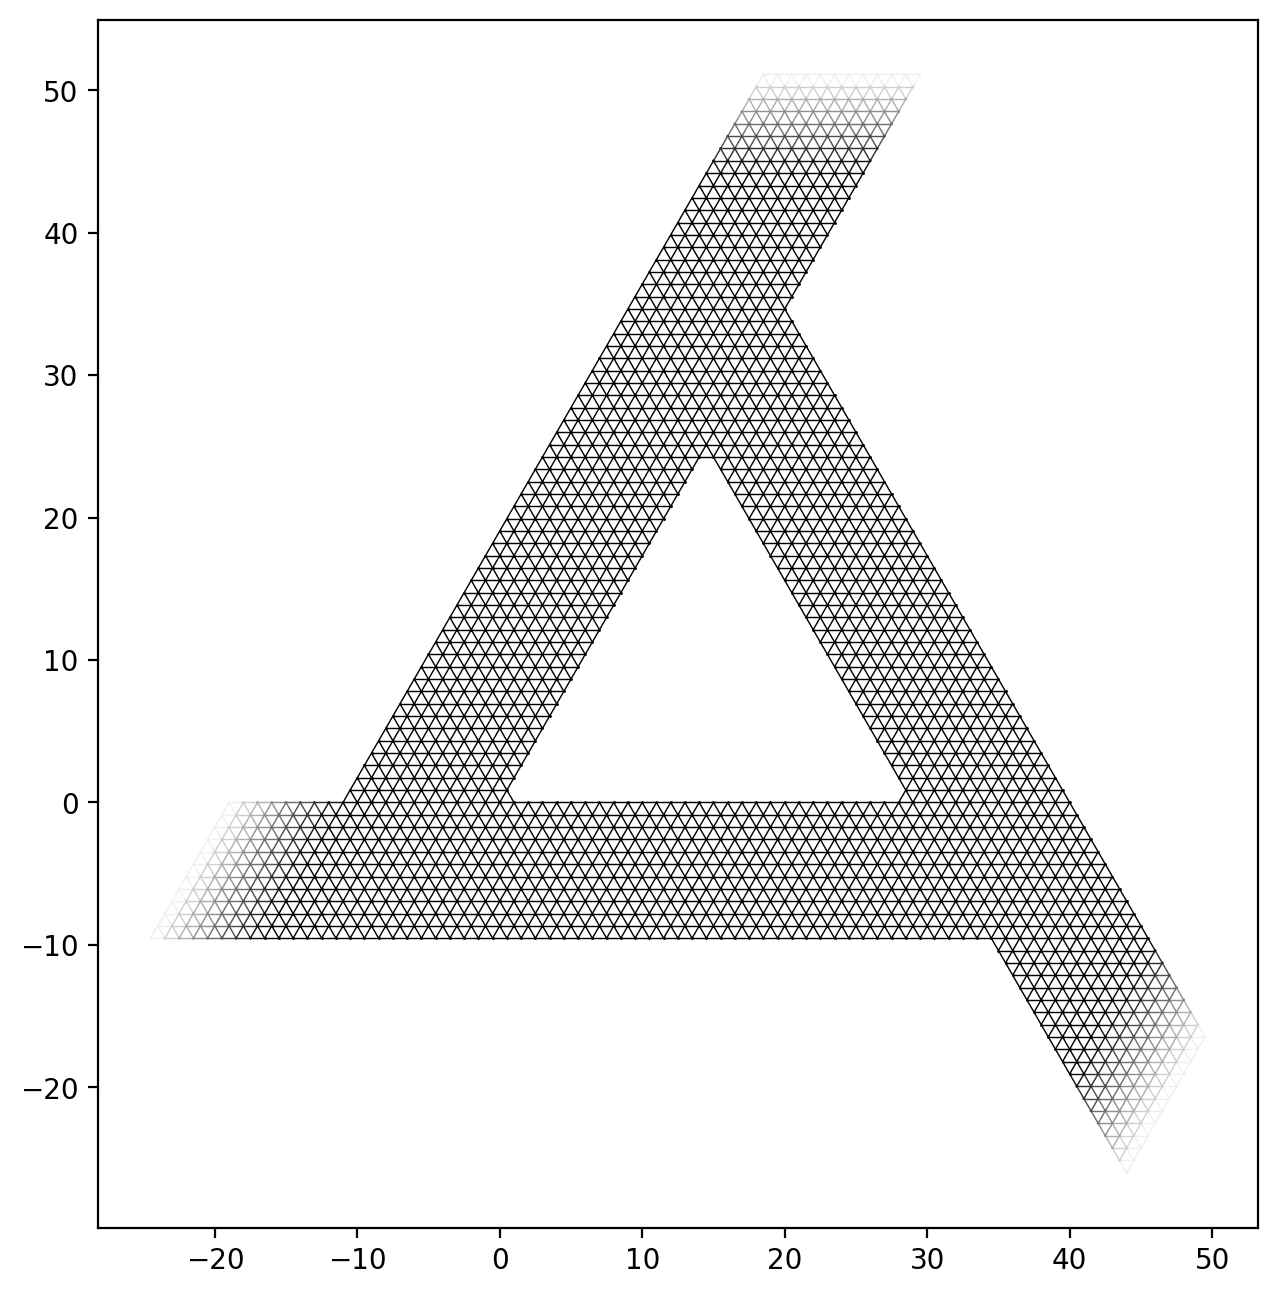

In [11]:
phi= pi/2
delta=0.3
theta1=0
theta2=0
theta3=0
L=29
W=11
Wl=W
syst = normal_leads(phi, delta, theta1, theta2, theta3,L,W,Wl)


fig=kwant.plot(syst, site_size=0.1,fig_size=(8, 8),site_color="k",lead_color='k', dpi=200, num_lead_cells=8);
fig.savefig("/Users/guilhermedelfino/Desktop/circulator.pdf")
plt.show()

# fsyst  = build_system(phi, delta, theta1, theta2, theta3,L,W).finalized()
# hamiltonian = fsyst.hamiltonian_submatrix(params=dict(phi=phi), sparse=False)
# eigenvalues = np.real(sorted(np.linalg.eigvals(hamiltonian)));

In [12]:
def conductance(en,L,W,Wl):

        # phi_ar= [i/40 for i in range(-120, 121)] #finer grid
        # delta_ar =[i/5 for i in range(1,20)] #finer grid

        # phi_ar = [i/10 for i in range(-30, 31)]
        # delta_ar =[i/10 for i in range(1,20)]

        phi_ar = [i/4 for i in range(-12, 12)]
        delta_ar =[i/5 for i in range(1,10)]

        # phi_ar = [i/6 for i in range(0, 12)]
        # delta_ar =[i/1000 for i in range(1,700)]
        
        size_phi = np.array(phi_ar).shape[0]
        size_del = np.array(delta_ar).shape[0]
        total = int(size_phi*size_del)

        conduc=np.zeros((size_phi, size_del))

        for i in range(0,size_phi):
                for j in range(0,size_del):
                        phi_el = phi_ar[i]
                        delta_el = delta_ar[j]

                        # df = pd.read_csv("data_fine/phi"+str(phi_el)+"delta"+str(delta_el)+".csv", header = None)

                        theta1=0.0
                        theta2=0.0
                        theta3=0.0
                        # theta2=df.values[2][1]
                        # theta3= df.values[3][1]


                        syst=normal_leads(phi_el*pi, delta_el, theta1, theta2, theta3,L,W,Wl);

                        smatrix = kwant.smatrix(syst.finalized(), en, params=dict(phi=phi_el*pi))

                        l=0
                        m= 1

                        GA_expij = smatrix.transmission((l, 0), (m, 0))
                        GA_expji = smatrix.transmission((m, 0), (l, 0))
                        
                        conduc[i,j]= GA_expij - GA_expji
                        print(i*size_del+j, " / ", total)
                        display.clear_output(wait=True)

        return phi_ar,delta_ar, conduc
        

en=0.01
L=5
W=0
Wl=0

phi_lab, delta_lab, GA=conductance(0.01,L,W,Wl)

215  /  216


24


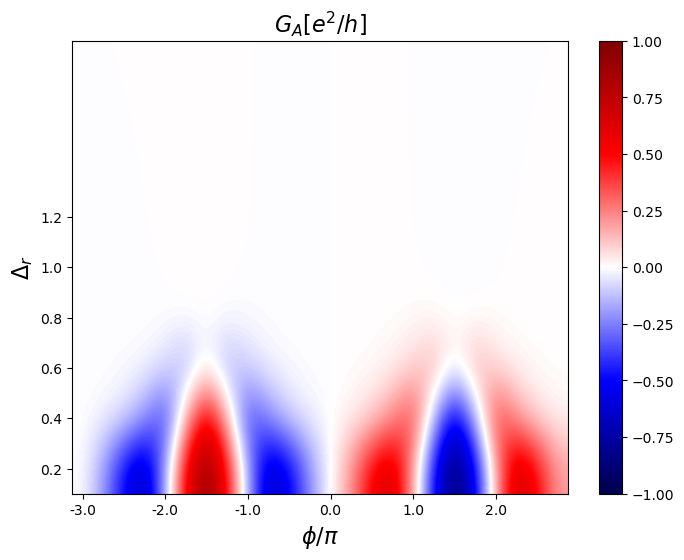

In [13]:
plt.figure(figsize=(8,6), dpi=100)
plt.imshow(np.transpose(GA), aspect = 'auto',origin='lower',interpolation='bicubic', cmap="seismic", vmin=-1, vmax=1)
plt.colorbar()

xtic, labelsx= label_plot(phi_lab)
ytic, labelsy = label_ploty(delta_lab)

plt.ylabel("$\Delta_r$",fontsize=16)
plt.title("$G_A[e^2/h]$",fontsize=16)

plt.xlabel("$\phi/\pi$",fontsize=16)
plt.xticks(xtic, labelsx)
plt.yticks(ytic, labelsy)
# plt.savefig("report/GA_L11W3Wl3.pdf")
plt.show()

In [235]:
1+1

2

29
24


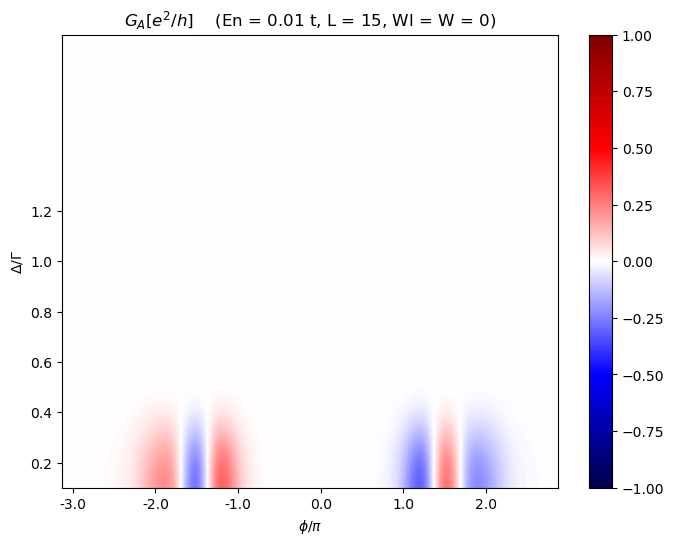

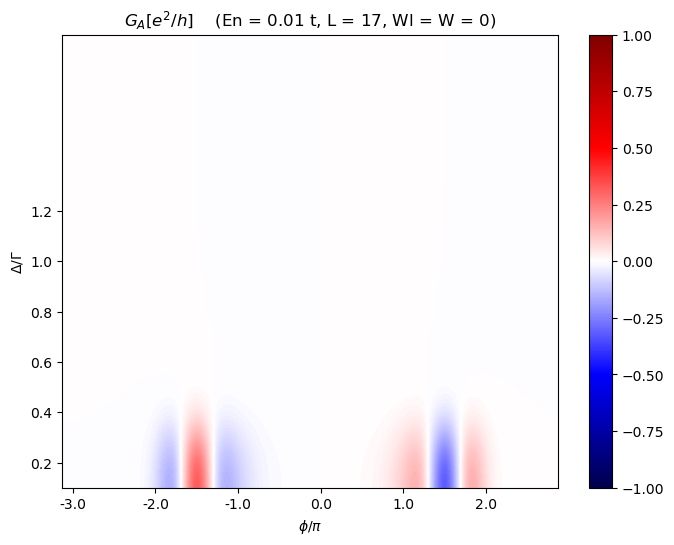

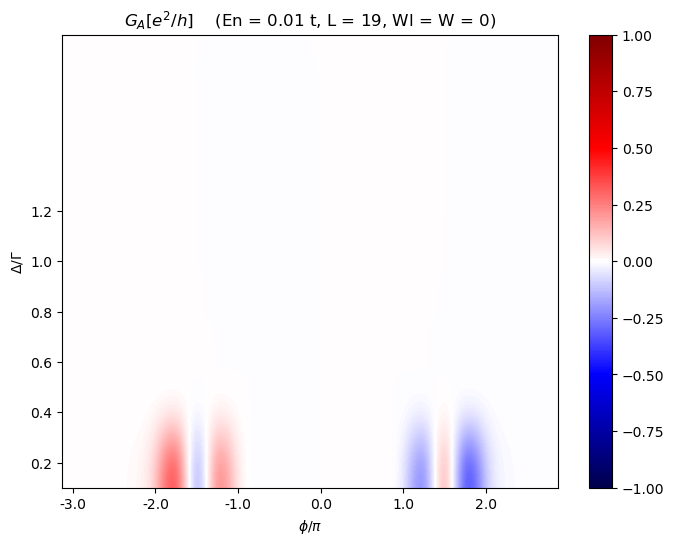

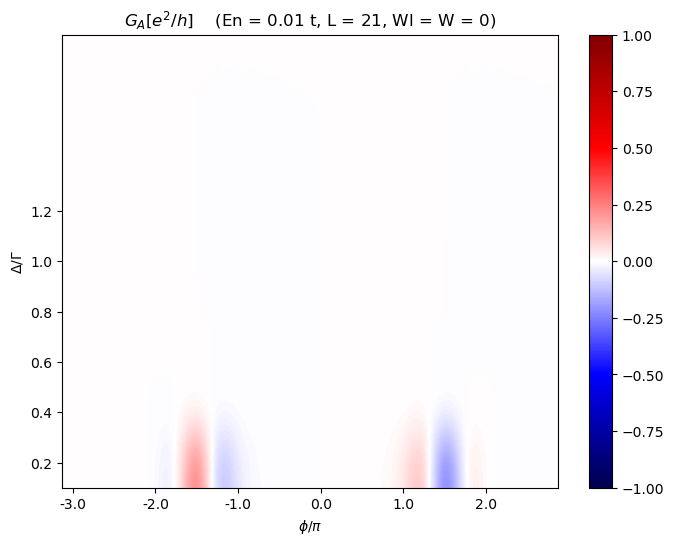

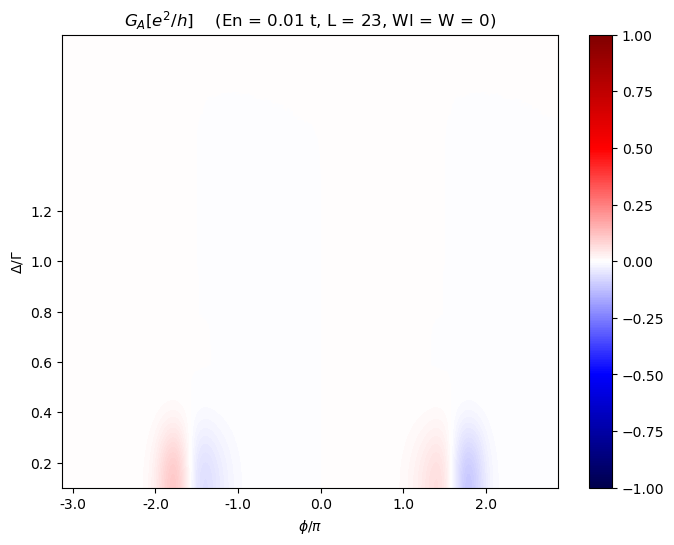

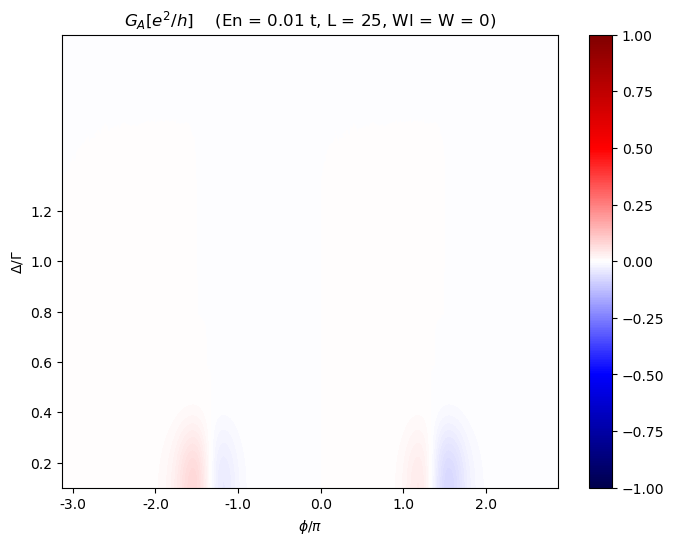

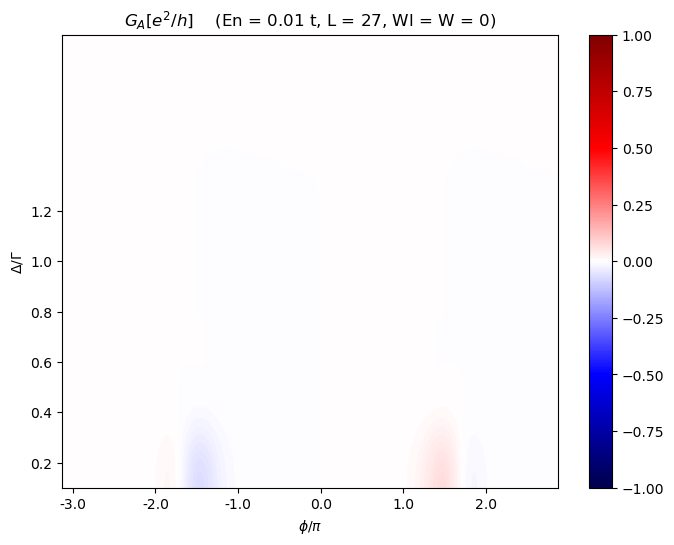

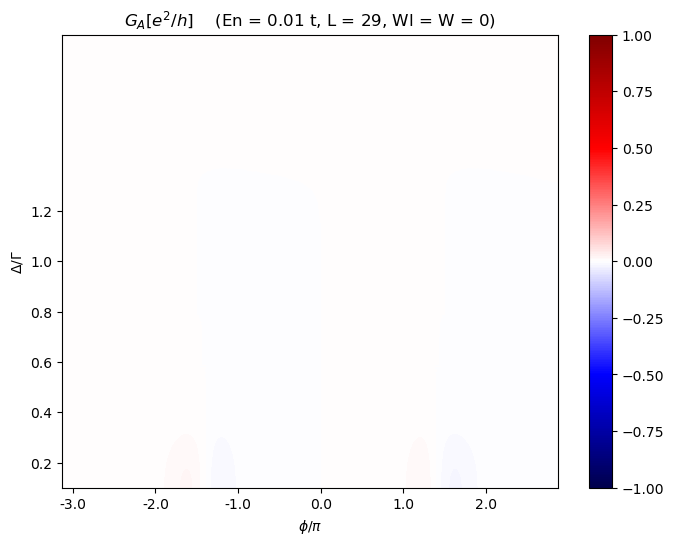

In [249]:
# Save figures to GIF
en=0.01

list_L = [i for i in range(15, 31,2)]

for L_elem in list_L:
    # W = int(L_elem/10)
    Wl=0
    W=0
    phi_lab, delta_lab, GA=conductance(0.01,L_elem,W,Wl)
    print(L_elem)

    plt.figure(figsize=(8,6), dpi=100)
    plt.imshow(np.transpose(GA), aspect = 'auto',origin='lower',interpolation='bicubic', cmap="seismic", vmin=-1, vmax=1);
    plt.colorbar()

    xtic, labelsx= label_plot(phi_lab)
    ytic, labelsy = label_ploty(delta_lab)

    plt.ylabel("$\Delta/\Gamma$")
    plt.title("$G_A[e^2/h]$    (En = "+str(0.01)+" t,"+" L = "+str(L_elem)+", Wl = W = "+str(W)+")")

    plt.xlabel("$\phi/\pi$")
    plt.xticks(xtic, labelsx)
    plt.yticks(ytic, labelsy)
    plt.savefig("report/gif/scaled/GA_L"+str(L_elem)+".pdf")



In [250]:
from pdf2image import convert_from_path
from PIL import Image
import imageio

images = []

pdf_files = ["report/gif/scaled/GA_L"+str(i)+".pdf" for i in range(1,31,2)]
for pdf in pdf_files:
    pages = convert_from_path(pdf, dpi=300)
    images.append(pages[0])
    
images[0].save("report/output_scaled.gif", save_all=True, append_images=images[1:], duration=500, loop=0)

In [14]:
def GAat3pi2(en,L,W,Wl):
    delta_ar =[i/1000 for i in range(1,600)]
    size_del = np.array(delta_ar).shape[0]
    flux = 3*pi/2 #+ pi/4
    conduc = np.zeros(size_del)

    for j in range(0,size_del):
        
        delta_el = delta_ar[j]

        theta1=0.0
        theta2=0.0
        theta3=0.0
        syst=normal_leads(flux, delta_el, theta1, theta2, theta3,L,W,Wl);

        smatrix = kwant.smatrix(syst.finalized(), en, params=dict(phi=flux))

        l=1
        m= 2

        GA_expij = smatrix.transmission((l, 0), (m, 0))
        GA_expji = smatrix.transmission((m, 0), (l, 0))
                        
        conduc[j]= GA_expij - GA_expji
        print(j, " / ", size_del)
        display.clear_output(wait=True)
        # print(W)

    return conduc
    

In [25]:
W=0
Wl=0
en=0.01

# Llist =[l for l in range(17,50,4)]
# Llist = [i for i in range(53, 120, 16)]
Llist = [i for i in range(9, 30, 4)]
Llistlen = len(Llist)
GAvsL = [GAat3pi2(en,l,W,Wl) for l in Llist ]

999  /  1000


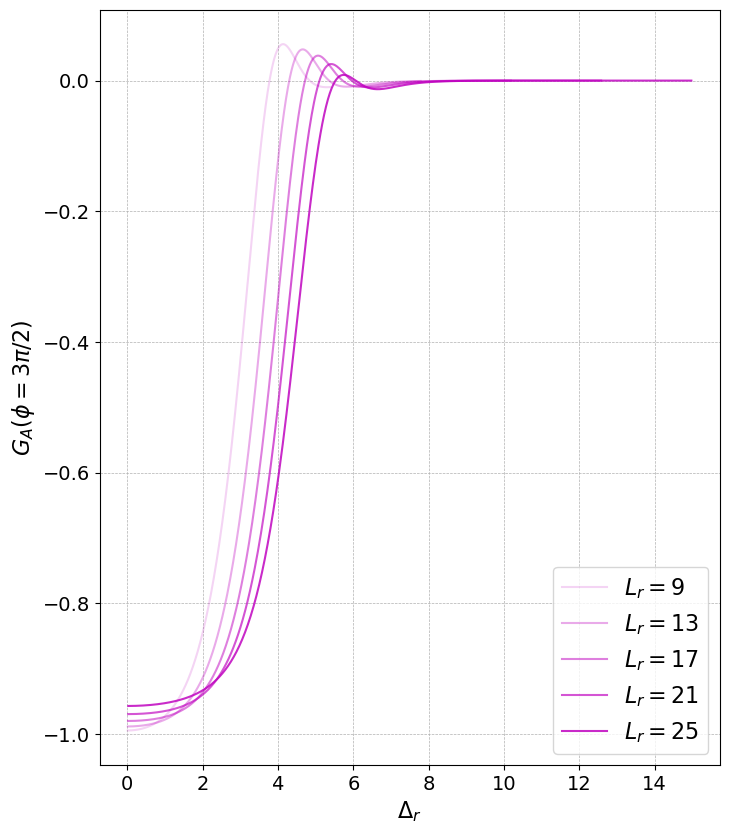

In [ ]:
delta_lab =[i/1000 for i in range(1,600)]
gradgradlist=[]

plt.figure(figsize=(8,10), dpi=100)
for i in range(Llistlen-1):

    elem = GAvsL[i]
    Li = Llist[i]

    # gradGA = np.gradient(elem, np.array(delta_lab)*Li)
    # gradgradGA = np.gradient(gradGA, np.array(delta_lab)*Li)
    # gradgradlist.append(gradgradGA)

   
    # plt.yscale('log')
    # plt.xscale('log')

    alpha0=(i+1)/6



    plt.plot(np.array(delta_lab)*Li, elem, label = "${L}_r = $"+str(Li), alpha = alpha0, color = "m", linewidth = 1.5)
    # plt.plot(np.array(delta_lab), np.abs(gradGA)/Li,label = "L = "+str(Li))
    plt.legend(loc='lower right',prop={'size': 16})
    plt.grid(True,linestyle="--", linewidth=0.5) 
    plt.xlabel("${\Delta}_r \,$",fontsize=16)
    plt.ylabel("$G_{A}(\phi = 3\pi/2)$",fontsize=16)
    plt.tick_params(axis='both', labelsize=14)
    # plt.title("$G_{A}(\phi = 3\pi/2)$")
    # plt.axhline(y=10**(-7))

# plt.savefig("/Users/guilhermedelfino/Desktop/GAat3pi2vsL.pdf")


In [24]:
delta_lab =[i/1000 for i in range(1,600)]
deltamax_ar = []
# gradgradGAmax_ar = []
# GA_min=[]

for i in range(Llistlen):

    elem = GAvsL[i]
    size_elem=len(elem)
    # GA_m=0

    # for j in range(size_elem):
    #     if np.abs(elem[j])<10**(-7): #Treshold
    #         GA_m = elem[j]
    #         deltamin = delta_ar[j]
    #         break

    max_loc=np.where(elem == elem.max())[0][0]
    deltamax = delta_lab[max_loc]
    Li = Llist[i]

    deltamax_ar.append(deltamax)
    # gradgradGAmax_ar.append(gradgradGAmax)
    # GA_min.append(GA_m)

x=np.log(Llist)[:-1]
y= np.log(deltamax_ar)[:-1]
m, c = np.polyfit(x,y, 1)
y_fit = m * x + c

plt.figure(figsize=(8,6), dpi=100)
plt.tick_params(axis='both', labelsize=14)

# plt.yscale('log')
# plt.xscale('log')
# plt.loglog(Llist, deltamin_ar,label = "W = "+str(W))


plt.plot(Llist[:-1], np.exp(y_fit), "--", color="k",label=r"Fit: ${\Delta_r}^* = a \, {L_r} ^{\alpha}$  with $(a,\alpha) = $("+str(np.round(np.exp(c),3))+", "+str(np.round(m,3))+")")
plt.loglog(Llist[:-1], (deltamax_ar)[:-1], " ",color="m", marker="o",alpha=0.8, markersize=8.0)
# plt.plot(deltamax_ar, np.e**(y_fit), 'r-', label=f'Fit: y = {m:.2f}x + {c:.2f}')
plt.legend(prop={'size': 16})



plt.xlabel("${L_r}$", fontsize=16)
plt.ylabel("${\Delta_r}\, ^*$",fontsize=16)
# plt.title("$\Delta^* \,\,  | \, \,\,  d G_A(\phi = 3 \pi/2)=0$", fontsize=16)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tick_params(axis='both', labelsize=14)
# plt.savefig("report/delta_threshold.pdf")
plt.savefig("/Users/guilhermedelfino/Desktop/report/deltavsL.pdf")
plt.show()

IndexError: list index out of range

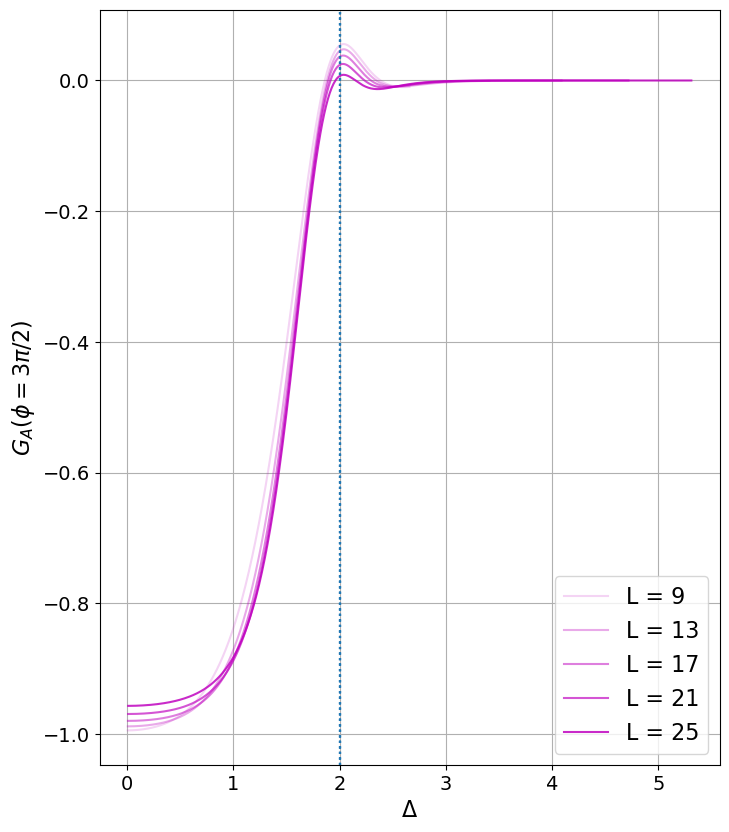

In [370]:
delta_lab =[i/1000 for i in range(1,600)]
gradgradlist=[]

plt.figure(figsize=(8,10), dpi=100)
for i in range(Llistlen-1):

    elem = GAvsL[i]
    Li = Llist[i]

    # gradGA = np.gradient(elem, np.array(delta_lab)*Li)
    # gradgradGA = np.gradient(gradGA, np.array(delta_lab)*Li)
    # gradgradlist.append(gradgradGA)

   
    # plt.yscale('log')
    # plt.xscale('log')

    alpha0=(i+1)/6



    plt.plot(np.array(delta_lab)*Li**0.678/(1**1.223),(elem), label = "L = "+str(Li), alpha = alpha0, color = "m", linewidth = 1.5)
    # plt.plot(np.array(delta_lab), np.abs(gradGA)/Li,label = "L = "+str(Li))
    plt.legend(loc='lower right',prop={'size': 16})
    plt.grid(True) 
    plt.xlabel("$\Delta \,$",fontsize=16)
    plt.ylabel("$G_{A}(\phi = 3\pi/2)$",fontsize=16)
    plt.tick_params(axis='both', labelsize=14)
    plt.axvline(x=2, linestyle="dotted")
    # plt.title("$G_{A}(\phi = 3\pi/2)$")
    # plt.axhline(y=10**(-7))

# plt.savefig("/Users/guilhermedelfino/Desktop/GAat3pi2vsL.pdf")


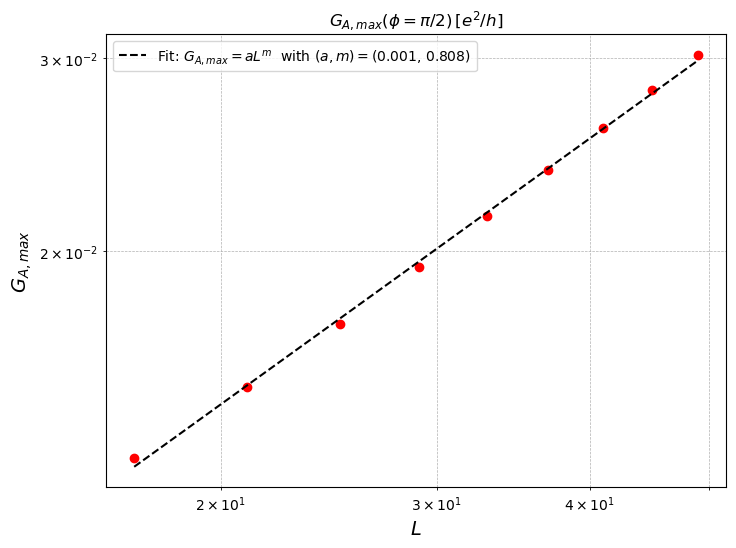

In [ ]:
a=15
delta_ar =[i/1000 for i in range(1,700)][a:]
deltamax_ar = []
GAmax_ar = []

for i in range(Llistlen):

    elem = GAvsL[i][a:]
    GAmax = elem.max()
    max_loc=np.where(elem == elem.max())[0][0]
    deltamax = delta_ar[max_loc]
    Li = Llist[i]

    deltamax_ar.append(deltamax)
    GAmax_ar.append(GAmax)

x=np.log(Llist)
y= np.log(GAmax_ar)
m, c = np.polyfit(x,y, 1)
y_fit = m * x + c

plt.figure(figsize=(8,6), dpi=100)

# plt.yscale('log')
# plt.xscale('log')
# plt.loglog(Llist, deltamax_ar,label = "W = "+str(W))


plt.plot(Llist, np.exp(y_fit), "--", color="k",label="Fit: $G_{A,max} = a L^{m}$  with $(a,m) = $("+str(np.round(np.exp(c),3))+", "+str(np.round(m,3))+")")
plt.loglog(Llist, (GAmax_ar), " ",color="r", marker="o")
# plt.plot(deltamax_ar, np.e**(y_fit), 'r-', label=f'Fit: y = {m:.2f}x + {c:.2f}')
plt.legend()



plt.xlabel("$L$", fontsize=14)
plt.ylabel("$G_{A,max}$",fontsize=14)
plt.title("$ G_{A,max}(\phi = \pi/2) \, [e^2/h]$")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
# plt.savefig("critical_delta.pdf")
plt.show()

## Exponential Tail

In [21]:
def GAat3pi2(en,L,W,Wl):
    delta_ar =[i/1000 for i in range(1000,2000)]
    size_del = np.array(delta_ar).shape[0]
    flux = 3*pi/2 #+ pi/4
    conduc = np.zeros(size_del)

    for j in range(0,size_del):
        
        delta_el = delta_ar[j]

        theta1=0.0
        theta2=0.0
        theta3=0.0
        syst=normal_leads(flux, delta_el, theta1, theta2, theta3,L,W,Wl);

        smatrix = kwant.smatrix(syst.finalized(), en, params=dict(phi=flux))

        l=1
        m= 2

        GA_expij = smatrix.transmission((l, 0), (m, 0))
        GA_expji = smatrix.transmission((m, 0), (l, 0))
                        
        conduc[j]= GA_expij - GA_expji
        print(j, " / ", size_del)
        display.clear_output(wait=True)
        # print(W)

    return conduc

W=0
Wl=0

Llist = [i for i in range(9, 30, 4)]
Llistlen = len(Llist)
GAvsL = [GAat3pi2(en,l,W,Wl) for l in Llist ]
    

999  /  1000


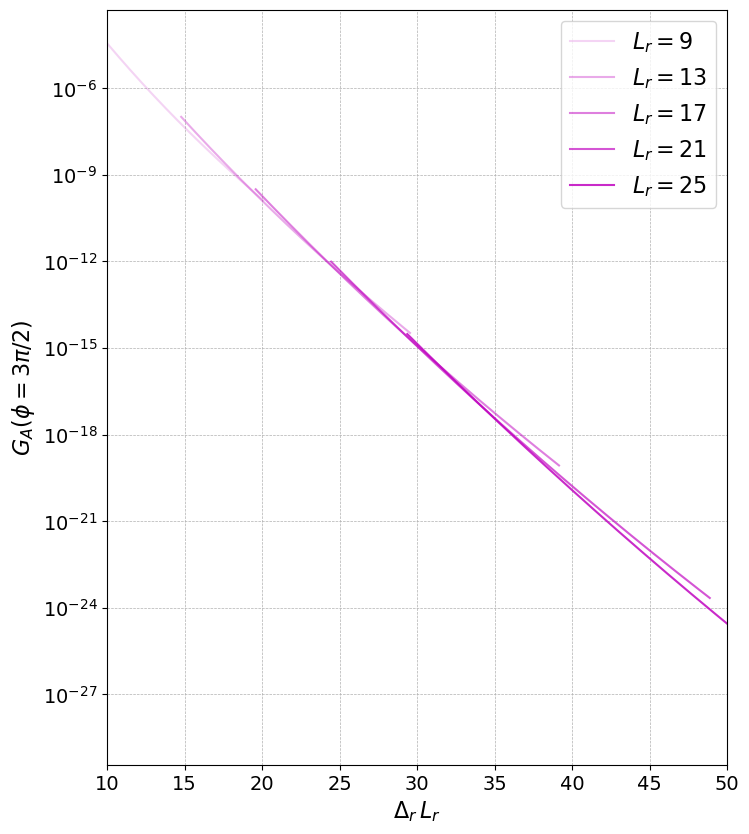

In [23]:
delta_lab =[i/1000 for i in range(1000,2000)]
gradgradlist=[]

plt.figure(figsize=(8,10), dpi=100)
for i in range(Llistlen-1):

    elem = GAvsL[i]
    Li = Llist[i]

    # gradGA = np.gradient(elem, np.array(delta_lab)*Li)
    # gradgradGA = np.gradient(gradGA, np.array(delta_lab)*Li)
    # gradgradlist.append(gradgradGA)

   
    plt.yscale('log')
    # plt.xscale('log')

    alpha0=(i+1)/6



    plt.plot(np.array(delta_lab)*Li**1.05, np.abs(elem), label = "${L}_r = $"+str(Li), alpha = alpha0, color = "m", linewidth = 1.5)
    # plt.plot(np.array(delta_lab), np.abs(gradGA)/Li,label = "L = "+str(Li))
    plt.legend(loc='upper right',prop={'size': 16})
    plt.grid(True,linestyle="--", linewidth=0.5) 
    plt.xlabel("${\Delta}_r \,{L}_r $",fontsize=16)
    plt.ylabel("$G_{A}(\phi = 3\pi/2)$",fontsize=16)
    plt.tick_params(axis='both', labelsize=14)
    # plt.title("$G_{A}(\phi = 3\pi/2)$")
    # plt.axhline(y=10**(-7))
    plt.xlim(10, 50)

plt.savefig("/Users/guilhermedelfino/Desktop/GAat3pi2vsL_exp_tail.pdf")


In [393]:
1+1

2

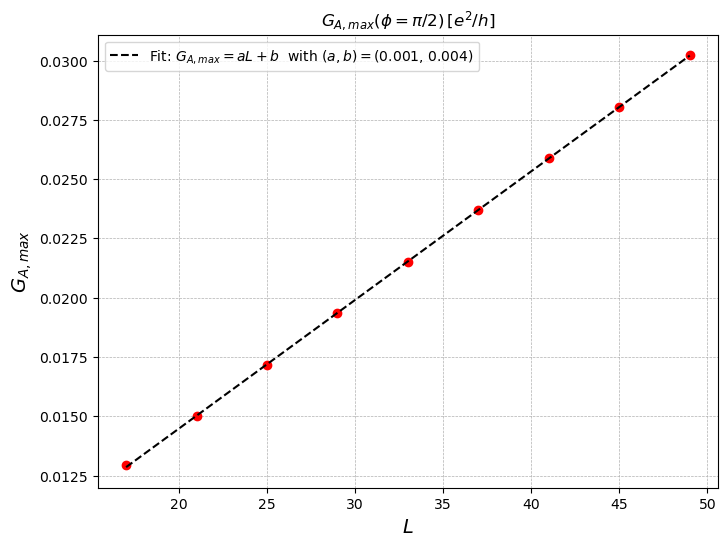

In [225]:

x=np.array(Llist)
y= np.array(GAmax_ar)
m, c = np.polyfit(x,y, 1)
y_fit = m * x + c

plt.figure(figsize=(8,6), dpi=100)

# plt.yscale('log')
# plt.xscale('log')
# plt.loglog(Llist, deltamax_ar,label = "W = "+str(W))

plt.plot(Llist, (GAmax_ar), " ",color="r", marker="o")
plt.plot(Llist, y_fit, "--", color="k",label="Fit: $G_{A,max} = a L+b$  with $(a,b) = $("+str(np.round(m,3))+", "+str(np.round(c,3))+")")
# plt.plot(deltamax_ar, np.e**(y_fit), 'r-', label=f'Fit: y = {m:.2f}x + {c:.2f}')
plt.legend()



plt.xlabel("$L$", fontsize=14)
plt.ylabel("$G_{A,max}$",fontsize=14)
plt.title("$ G_{A,max}(\phi = \pi/2) \, [e^2/h]$")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
# plt.savefig("critical_delta.pdf")
plt.show()

In [381]:
L=21 #fix L
#gamma=1
# Wl=0

Wlist =[w for w in range(0,13,4)]
Wlistlen = len(Wlist)
GAvsW = [GAat3pi2(en,L,w,0) for w in Wlist]

598  /  599


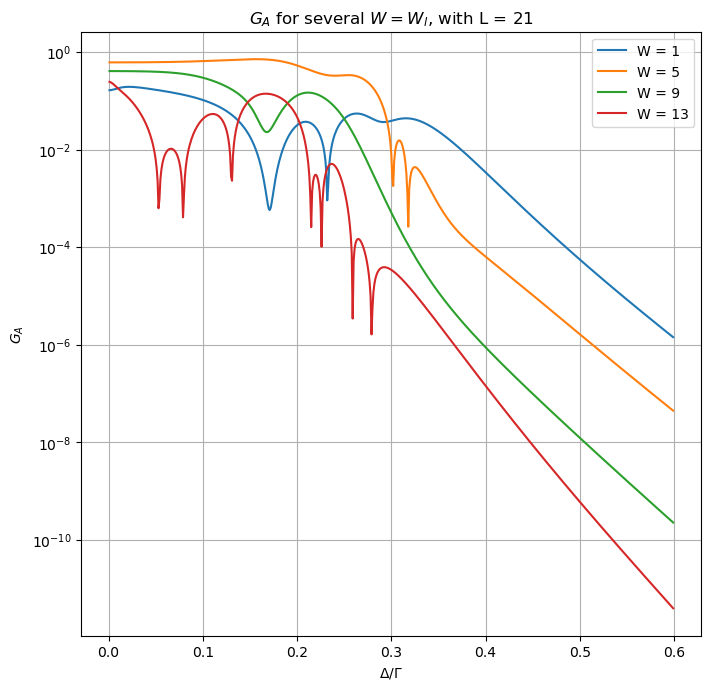

In [ ]:
delta_lab =[i/1000 for i in range(1,600)]
plt.figure(figsize=(8,8),dpi=100)
for i in range(Wlistlen):

    elem = GAvsW[i]
    Wi = Wlist[i]
    
    
    plt.yscale('log')
    plt.plot(np.array(delta_lab), np.abs(elem),label = "W = "+str(Wi))
    plt.legend()
    plt.grid(True) 
    plt.title("$G_A$ for several $W$, with L = "+str(L)+"and Wl = 0")

plt.xlabel("$\Delta/\Gamma$")
plt.ylabel("$G_A$")
plt.savefig("report/GAvsW.pdf")
plt.show()

In [113]:
1+1

2

In [ ]:
### Energy 

##Plot the gap \Delta E(L)/L^{d-1} vs \Delta at different L. The crossing gives \Delta_c 



In [297]:
def energyatpi2(L,W):
    flux = pi/2
    delta_lab =[i/40 for i in range(1,80)]
    # size = len(delta_lab)
    ans_gs=[]
    ans_gap=[]
    for delta in delta_lab:

        fsyst  = build_system(flux, delta, theta1, theta2, theta3,L,W).finalized()
        hamiltonian = fsyst.hamiltonian_submatrix(params=dict(phi=flux), sparse=False)
        eigenvalues = np.real(sorted(np.linalg.eigvals(hamiltonian)));

        middle = int(np.array(eigenvalues).shape[0]/2)
        gs_en = sum(eigenvalues[0:middle])
        gap = eigenvalues[middle] -  eigenvalues[middle-1]

        ans_gap.append(gap)
        ans_gs.append(gs_en) #ground state energy 
    return ans_gap#, ans_gs

In [298]:
Llist =[l for l in range(17,100,16)]
Llistlen = len(Llist)
ener_gap = [energyatpi2(L,0) for L in Llist]

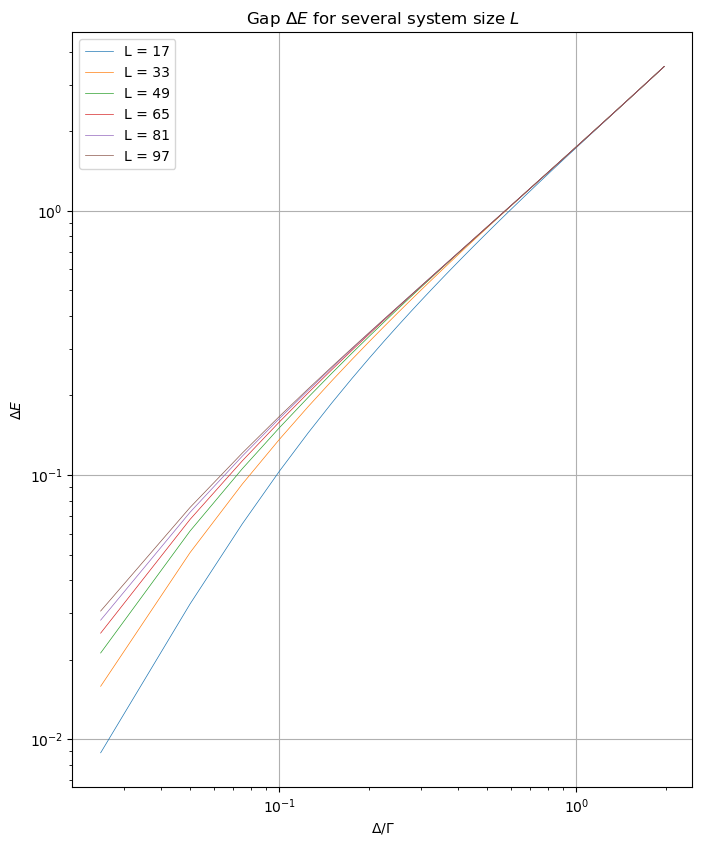

In [302]:
Llist =[l for l in range(17,100,16)]
Llistlen = len(Llist)
delta_lab =[i/40 for i in range(1,80)]

plt.figure(figsize=(8,10), dpi=100)
for i in range(Llistlen):

    elem = ener_gap[i]
    Li = Llist[i]
   
    plt.yscale('log')
    plt.xscale('log')
    plt.title("Gap $\Delta E$ for several system size $L$")
    plt.xlabel("$\Delta/\Gamma$")
    plt.ylabel("$\Delta E$")

    plt.plot(np.array(delta_lab), np.array(elem),label = "L = "+str(Li), linewidth  = 0.5)
    plt.legend()
    plt.grid(True) 


## Free Energy

In [271]:
#### Free energy

def free_energyatpi2(L,W):
    beta=2
    flux = 3*pi/2
    delta_lab =[i/20 for i in range(1,40)]
    # size = len(delta_lab)
    ans_F=[]
    for delta in delta_lab:

        fsyst  = build_system(flux, delta, theta1, theta2, theta3,L,W).finalized()
        hamiltonian = fsyst.hamiltonian_submatrix(params=dict(phi=flux), sparse=False)
        eigenvalues = np.real(sorted(np.linalg.eigvals(hamiltonian)));

        middle = int(np.array(eigenvalues).shape[0]/2)
        Z = sum(np.exp(-beta*eigenvalues[0:middle]))
        ans_F.append(-np.log(Z))

    return ans_F#, ans_gs

In [269]:
delta_lab =[i/1000 for i in range(1,700)]
F11=free_energyatpi2(21,0)



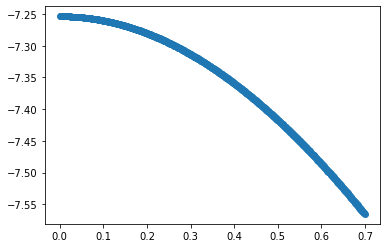

In [270]:
plt.scatter(delta_lab, F11)

In [272]:
Llist =[l for l in range(17,50,4)]
Llistlen = len(Llist)
free_energy = [free_energyatpi2(l,2) for l in Llist]

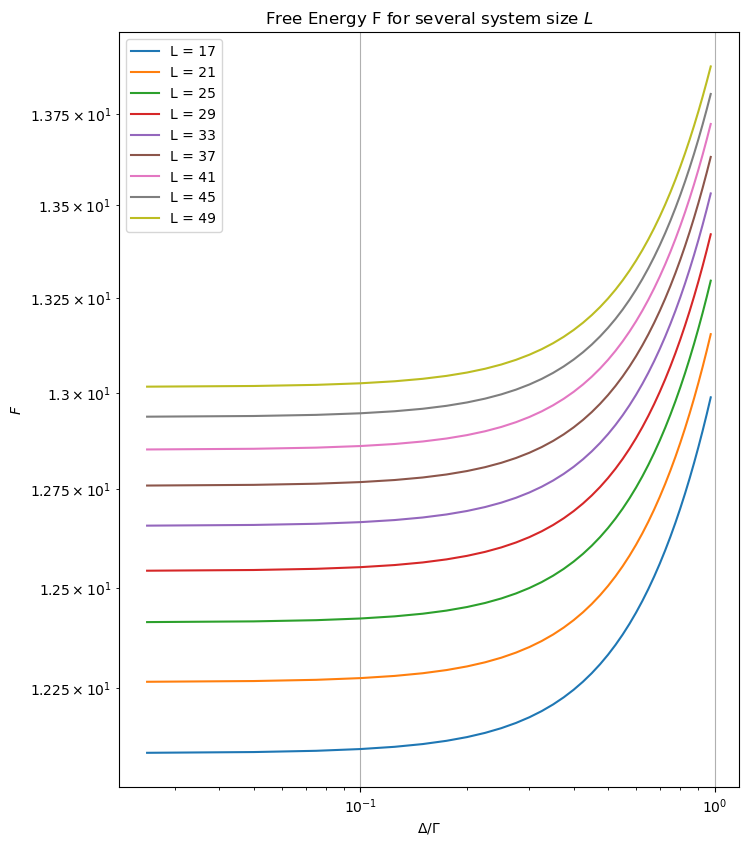

In [277]:
delta_lab =[i/40 for i in range(1,40)]

plt.figure(figsize=(8,10), dpi=100)
for i in range(Llistlen):

    elem = free_energy[i]
    Li = Llist[i]
   
    plt.yscale('log')
    plt.xscale('log')
    plt.title("Free Energy F for several system size $L$")
    plt.xlabel("$\Delta/\Gamma$")
    plt.ylabel("$F$")

    plt.plot(np.array(delta_lab), np.abs(elem),label = "L = "+str(Li))
    plt.legend()
    plt.grid(True) 

In [26]:
## Gs

In [39]:
def GSconductance(en,L,W,Wl):

        # phi_ar= [i/40 for i in range(-120, 121)] #finer grid
        # delta_ar =[i/5 for i in range(1,20)] #finer grid

        # phi_ar = [i/10 for i in range(-30, 31)]
        # delta_ar =[i/10 for i in range(1,20)]

        phi_ar = [i/4 for i in range(-12, 12)]
        delta_ar =[i/5 for i in range(1,10)]
        
        size_phi = np.array(phi_ar).shape[0]
        size_del = np.array(delta_ar).shape[0]
        total = int(size_phi*size_del)

        conduc=np.zeros((size_phi, size_del))

        for i in range(0,size_phi):
                for j in range(0,size_del):
                        phi_el = phi_ar[i]
                        delta_el = delta_ar[j]

                        # df = pd.read_csv("data_fine/phi"+str(phi_el)+"delta"+str(delta_el)+".csv", header = None)

                        theta1=0.0
                        theta2=0.0
                        theta3=0.0
                        # theta2=df.values[2][1]
                        # theta3= df.values[3][1]


                        syst=normal_leads(phi_el*pi, delta_el, theta1, theta2, theta3,L,W,Wl);

                        smatrix = kwant.smatrix(syst.finalized(), en, params=dict(phi=phi_el*pi))

                        l=0
                        m= 1

                        GA_expij = smatrix.transmission((l, 0), (m, 0))
                        GA_expji = smatrix.transmission((m, 0), (l, 0))
                        
                        conduc[i,j]= GA_expij + GA_expji
                        print(i*size_del+j, " / ", total)
                        display.clear_output(wait=True)

        return phi_ar,delta_ar, conduc
        

en=0.01
L=21
W=3
Wl=3

phi_lab, delta_lab, GS=GSconductance(0.01,L,W,Wl)

215  /  216


24


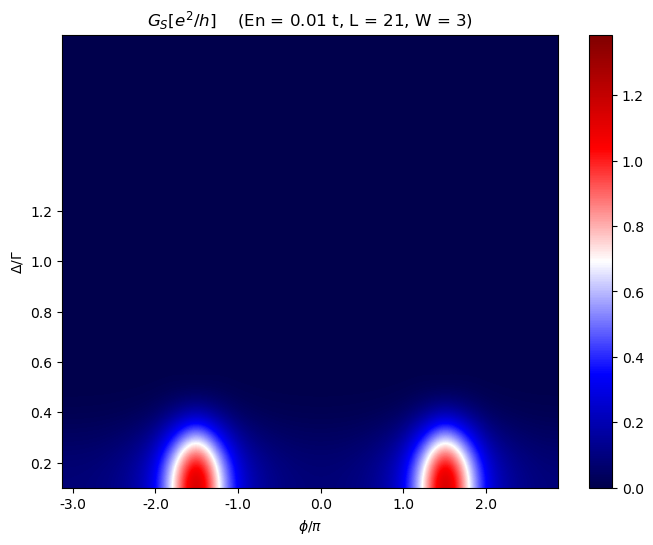

In [40]:
plt.figure(figsize=(8,6), dpi=100)
plt.imshow(np.transpose(GS), aspect = 'auto',origin='lower',interpolation='bicubic', cmap="seismic")
plt.colorbar()

xtic, labelsx= label_plot(phi_lab)
ytic, labelsy = label_ploty(delta_lab)

plt.ylabel("$\Delta/\Gamma$")
plt.title("$G_S[e^2/h]$    (En = "+str(0.01)+" t,"+" L = "+str(L)+", W = "+str(W)+")")

plt.xlabel("$\phi/\pi$")
plt.xticks(xtic, labelsx)
plt.yticks(ytic, labelsy)
# plt.savefig("report/GS_L7W0Wl0.pdf")
plt.show()

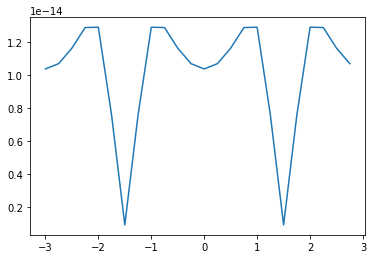

In [45]:
plt.plot(phi_lab,GS[:,8])

In [ ]:
## Exponential Tail